In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

### Functions used in this code
import density_functions as dfunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

#parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16 r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-9999.0)&(r13['LOGG']>0.0)&\
                (r13['M_H_ERR']>-90.0)&(r13['C_FE']>-9999.0)&(r13['N_FE']>-9999.0))

r13 = r13[clnr]

#Transform APOGEE RA and DEC to Magellanic Stream L and B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

In [3]:
##############
### Fields ###
##############

field_str = ['30Dor','LMC1','LMC2','LMC3','LMC4','LMC5','LMC6','LMC7','LMC8','LMC9','LMC10','LMC11','LMC12',
             'LMC13','LMC14','LMC15','LMC16','LMC17']

In [4]:
### blue loop cut
bloop = np.where((r13['TEFF']>=4100)&(r13['H']<=13.0)&((r13['J']-r13['K'])<=0.95))

bloop_cut = []
for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    if i not in np.squeeze(r13).tolist():
        bloop_cut.append(i)
        
bloopr13 = r13[bloop_cut]

fields = []
for i in range(len(field_str)):
    fields.append(np.where(bloopr13['FIELD']==field_str[i]))

In [156]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE']+r13['FE_H']-r13['M_H']))
    x_N.append(sol_xm[1]*10**(r13['N_FE']+r13['FE_H']-r13['M_H']))
    x_O.append(sol_xm[2]*10**(r13['O_FE']+r13['FE_H']-r13['M_H']))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE']+r13['FE_H']-r13['M_H']))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE']+r13['FE_H']-r13['M_H']))
    x_S.append(sol_xm[5]*10**(r13['S_FE']+r13['FE_H']-r13['M_H']))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE']+r13['FE_H']-r13['M_H']))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H']-r13['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

xLMC, yLMC, stardist = dfunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = dfunc.absmag(r13['K'],stardist)-r13['AK_TARG']
parage = dfunc.find_age(np.log10(r13['TEFF']),corabsK,dfunc.sal(r13['M_H'],metscorr),r13['LOGG'])
parage = np.squeeze(parage)

#bloop cut ages
bloopage = parage[bloop_cut]
bloopabsH = (dfunc.absmag(r13['H'],stardist)-r13['AK_TARG'])[bloop_cut]

In [7]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

################################
### Calculate  Uncertainties ###
################################

devs = []
halo_cutoff = -2.0

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR']
    
    noise_ages = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = dfunc.add_noise(teff,teff_err) 
    
        # Calculate noisy K magnitude
        _, _, dist = dfunc.LMCdisk_cart(ra,dec)
        
        ks_new = dfunc.add_noise(ks,ks_err)
        
#         if feh <= halo_cutoff:
#             dist_new = add_pos_noise(dist,1.0)
#             absK_new = dfunc.absmag(ks_new,dist_new) - ak
        
#         else:
        absK_new = dfunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        ffac_new = dfunc.sal_noise(cfe,cfe_err,nfe,nfe_err,feh,feh_err,mh,mh_err)
        
        mh_new = dfunc.add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = dfunc.add_noise(lgg,lgg_err)
            
        # calculate noisy age
        noise_ages.append(dfunc.find_age(np.log10(teff_new),absK_new,dfunc.sal(mh_new,ffac_new),lgg_new))
    
    devs.append(dfunc.mad(noise_ages))
    
bloopage_devs = np.asarray(devs)[bloop_cut]

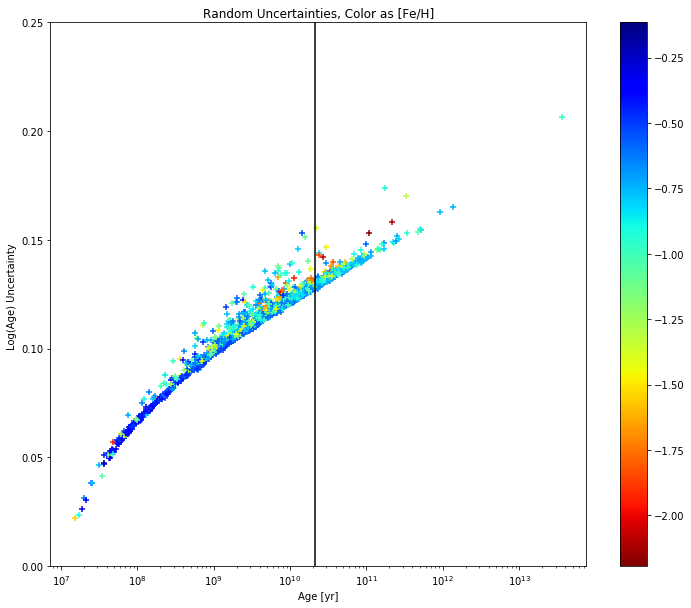

In [8]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parage),devs,marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.max(devs)),c='k')
plt.xscale('log')
plt.ylim(0,0.25)
plt.title(r'Random Uncertainties, Color as [Fe/H]')
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty ')
plt.show()

In [12]:
########################
### Area Calculation ###
########################

### pc^2
field_ang = [0.8,0.95,0.95,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.95,0.8,0.8,0.8,0.95,0.8]
field_areas = np.multiply(np.pi*np.square(np.multiply(field_ang,0.875)),10**6)

###################################
### Calculate the fields masses ###
###################################

iso_ages = []
iso_zs = []

#fnt and brt bins
fbins = dfunc.brtfntlmc_bins(bloopr13)

for i in range(len(field_str)):
    fd = np.where(bloopr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(bloopage[fd]),np.median(bloopr13[fd]['FE_H']))
    iso_ages.append(age)
    iso_zs.append(z)

absHs = []
for i in range(len(field_str)):
    field_H = np.where(bloopr13['FIELD']==field_str[i]) 
    absHs.append(np.asarray(bloopabsH)[field_H])

sf_brites = []
sf_faints = []
for i,j in enumerate(fbins):
    if i in np.arange(len(fbins))[1::2]:
        sf_brites.append(bloopr13[fbins[j]]['SELECTFUNC'])
    if i in np.arange(len(fbins))[0::2]:
        sf_faints.append(bloopr13[fbins[j]]['SELECTFUNC'])
        
field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    field_masses.append(dfunc.fieldmass(iso_ages[i],iso_zs[i],absHs[i],sf_brites[i],sf_faints[i],parsec))
#print(field_masses)

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   18
Model:                            RLM   Df Residuals:                       16
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 02 Apr 2020                                         
Time:                        20:01:58                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3046      0.403     13.178      0.0

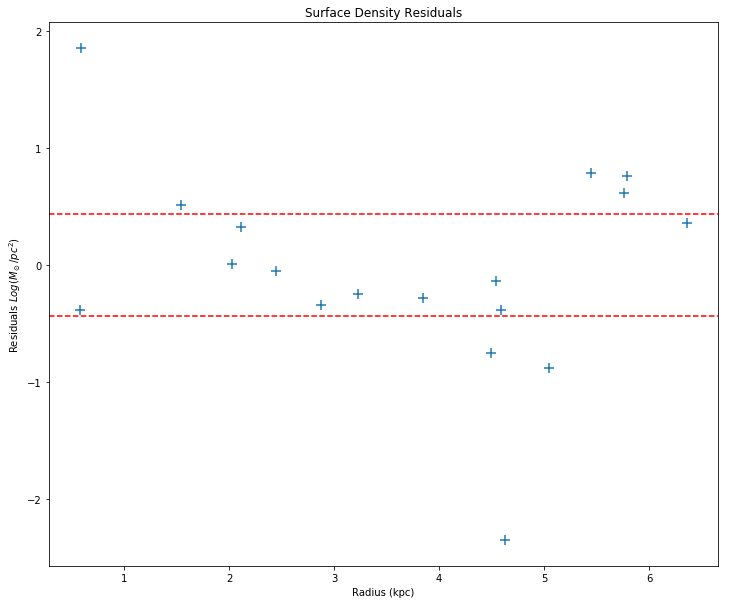

mad(Residual): 0.43657735353458377


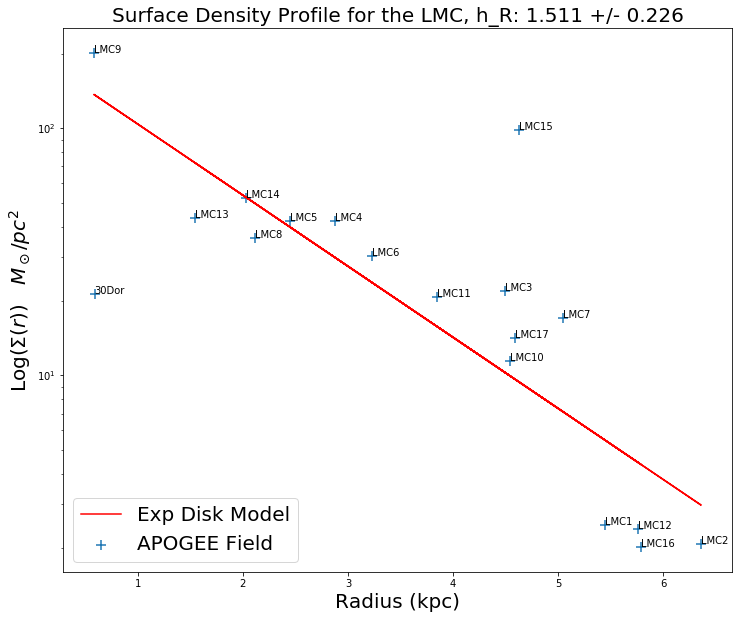

In [54]:
### Calculate Surface Densities and Density Profile

import statsmodels.api as sm

surfden = []
for i in range(len(field_masses)):
    surfden.append(np.divide(field_masses[i],field_areas[i]))
    
'''
model is sigma = A*exp(B*r)
A central density 
B radial scale height 
r radius

ln(sigma) = lnA + B*r
'''

import statsmodels.api as sm 

field_list = [np.where(bloopr13['FIELD']=='30Dor'),np.where(bloopr13['FIELD']=='LMC1'),
              np.where(bloopr13['FIELD']=='LMC2'),np.where(bloopr13['FIELD']=='LMC3'),
              np.where(bloopr13['FIELD']=='LMC4'),np.where(bloopr13['FIELD']=='LMC5'),
              np.where(bloopr13['FIELD']=='LMC6'),np.where(bloopr13['FIELD']=='LMC7'),
              np.where(bloopr13['FIELD']=='LMC8'),np.where(bloopr13['FIELD']=='LMC9'),
              np.where(bloopr13['FIELD']=='LMC10'),np.where(bloopr13['FIELD']=='LMC11'),
              np.where(bloopr13['FIELD']=='LMC12'),np.where(bloopr13['FIELD']=='LMC13'),
              np.where(bloopr13['FIELD']=='LMC14'),np.where(bloopr13['FIELD']=='LMC15'),
              np.where(bloopr13['FIELD']=='LMC16'),np.where(bloopr13['FIELD']=='LMC17')]

radii = []

for i in range(len(field_str)):
    radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(bloopr13['RA'][field_list[i]],
                                                      bloopr13['DEC'][field_list[i]])[0])**2 + 
                         np.median(dfunc.LMCdisk_cart(bloopr13['RA'][field_list[i]],
                                                      bloopr13['DEC'][field_list[i]])[1])**2))
    

model = np.array([radii]).T
model = sm.add_constant(model)
model_model = sm.RLM(np.log(surfden),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(surfden)
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))

plt.figure(figsize=[12,10])
plt.scatter(radii,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
plt.show()
print('mad(Residual):',dfunc.mad(model_residual))

def lmcdensityprofile(r):
    p = [ 5.30458805, -0.66202375]
    return p[0]+np.multiply(p[1],r)

plt.figure(figsize=[12,10])

plt.scatter(radii,surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
for i in range(len(radii)):
    plt.text(radii[i],surfden[i],'{}'.format(['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 
                                              'LMC8','LMC9', 'LMC10', 'LMC11', 'LMC12', 'LMC13', 'LMC14', 'LMC15',
                                              'LMC16', 'LMC17'][i]))
plt.plot(radii,np.exp(lmcdensityprofile(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title(r'Surface Density Profile for the LMC, h_R: {:.3f} +/- {:.3f}'.format(np.reciprocal(0.66202375),
                                                                                0.099*np.reciprocal(0.66202375**2)),fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('lmcdensityprofile.pdf',bbox_inches='tight')
plt.show()

## Remove 30 Dor

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     35.29
Date:                Thu, 02 Apr 2020   Prob (F-statistic):           2.71e-05
Time:                        20:03:41   Log-Likelihood:                -18.835
No. Observations:                  17   AIC:                             41.67
Df Residuals:                      15   BIC:                             43.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5458      0.483     11.474      0.0

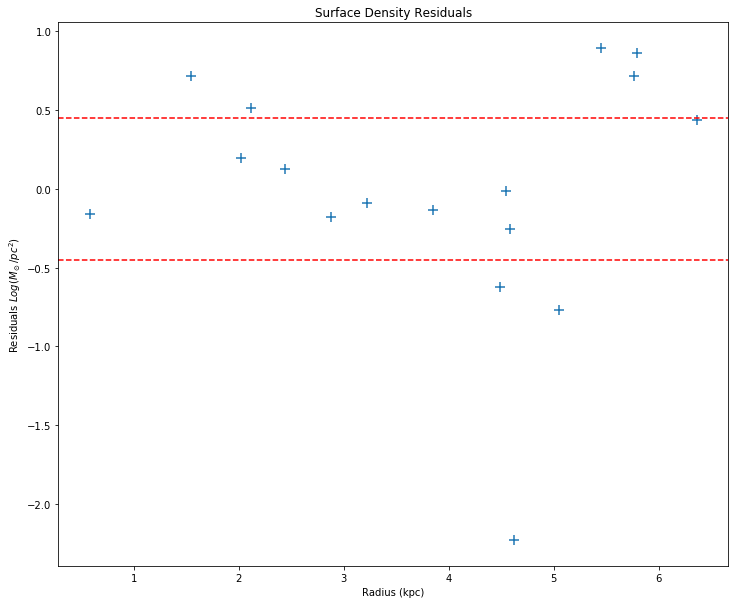

mad(Residual): 0.4509105264553702


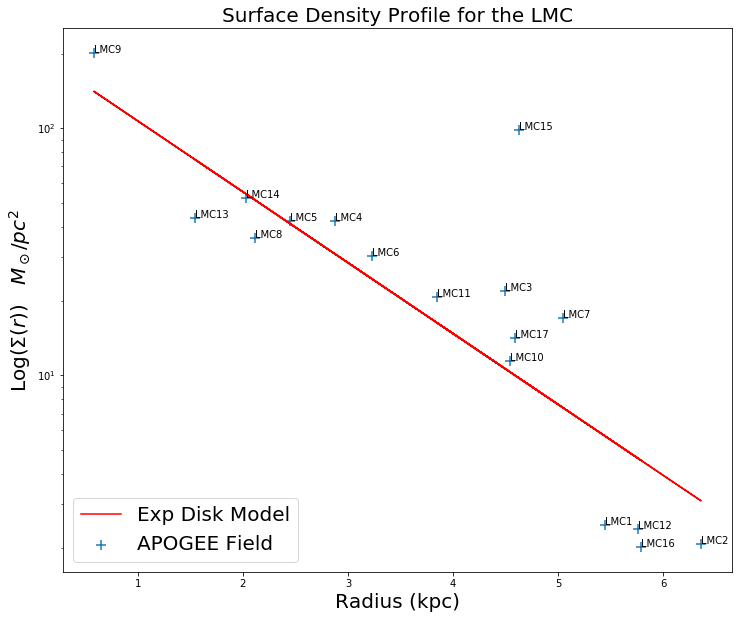

In [57]:
radii_rm30dor = np.delete(radii,0)
surfden_rm30dor = np.delete(surfden,0)

model = np.array([radii_rm30dor]).T
model = sm.add_constant(model)
model_model = sm.OLS(np.log(surfden_rm30dor),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(surfden_rm30dor)
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))

plt.figure(figsize=[12,10])
plt.scatter(radii_rm30dor,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# plt.colorbar()
# plt.savefig('residexpmodel.pdf',bbox_inches='tight')
plt.show()
print('mad(Residual):',dfunc.mad(model_residual))

def lmcdensityprofile_rm30dor(r):
    p = [5.33212892, -0.66014156] 
    return p[0]+np.multiply(p[1],r)

plt.figure(figsize=[12,10])

plt.scatter(np.delete(np.copy(radii),0),np.delete(np.copy(surfden),0),marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
for i in np.delete(range(len(radii)),0):
    plt.text(radii[i],surfden[i],'{}'.format(['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8',
       'LMC9', 'LMC10', 'LMC11', 'LMC12', 'LMC13', 'LMC14', 'LMC15',
       'LMC16', 'LMC17'][i]))
plt.plot(radii,np.exp(lmcdensityprofile_rm30dor(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('lmcdensityprofile_rm30dor.pdf',bbox_inches='tight')
plt.show()

In [58]:
np.reciprocal(0.7186)

1.3915947676036737

<font size='20'>
    <b>
        Binned Metallicity
    </b>
</font>

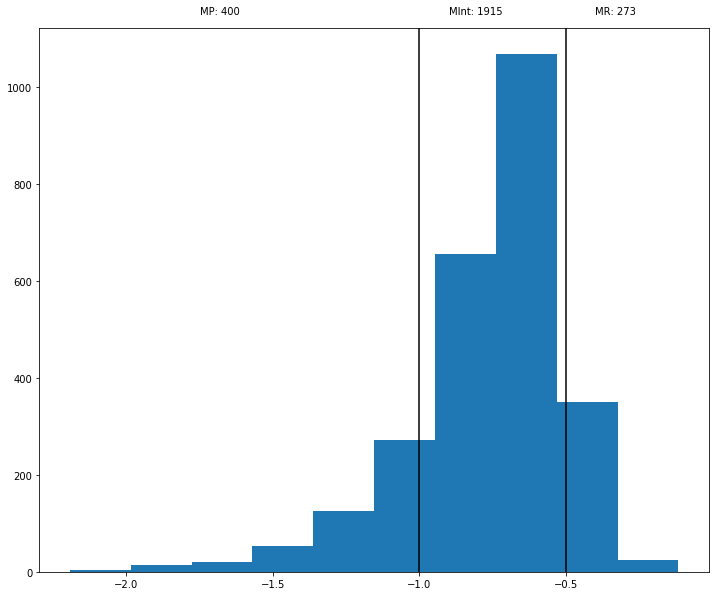

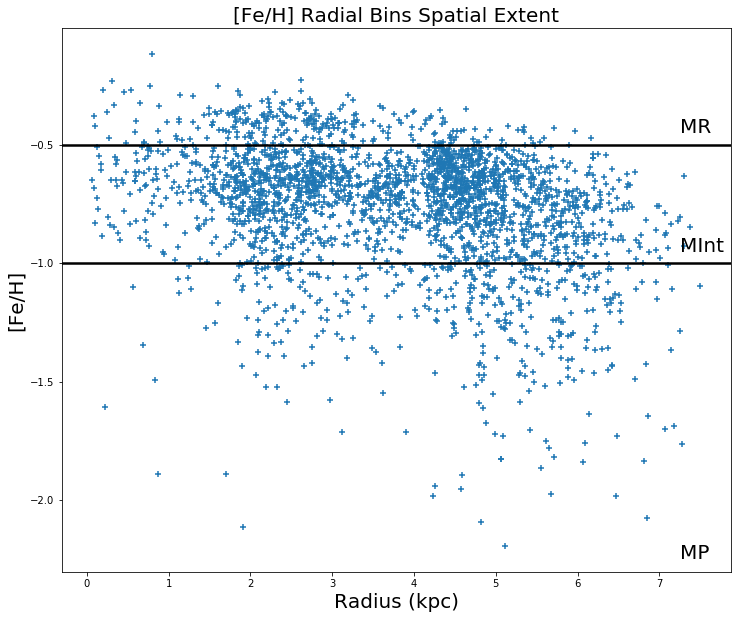

In [172]:
## Metallicity histogram with bins
plt.figure(figsize=[12,10])
plt.hist(r13['FE_H'])
plt.axvline(-1.0,c='k')
plt.axvline(-0.5,c='k')
plt.text(-1.75,1150,'MP: {}'.format(len(np.squeeze(np.where(r13['FE_H']<-1.0)))))
plt.text(-0.9,1150,'MInt: {}'.format(len(np.squeeze(np.where((r13['FE_H']<-0.5)&(r13['FE_H']>-1.0))))))
plt.text(-0.4,1150,'MR: {}'.format(len(np.squeeze(np.where(r13['FE_H']>-0.5)))))
plt.show()

## Metallicity as function of radius
plt.figure(figsize=[12,10])
plt.scatter(np.sqrt(xLMC**2+yLMC**2),r13['FE_H'],marker='+',c='tab:blue')
plt.axhline(-0.5,c='k',lw=2.5)
plt.axhline(-1.0,c='k',lw=2.5)

plt.title(r'[Fe/H] Radial Bins Spatial Extent',fontsize=20)

plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'[Fe/H]',fontsize=20)

plt.text(7.25,-0.45,'MR',fontsize=20)
plt.text(7.25,-0.95,'MInt',fontsize=20)
plt.text(7.25,-2.25,'MP',fontsize=20)
plt.show()

## Bin by metallicity
mp = np.where(r13['FE_H']<-1.0)
mint = np.where((r13['FE_H']>=-1.0)&(r13['FE_H']<-0.5))
mr = np.where(r13['FE_H']>=-0.5)

#Metal Poor
mpr13 = bloopr13[mp]
mpages = bloopage[mp]
mpabsH = bloopabsH[mp]

#Metal Intermediate 
mintr13 = bloopr13[mint]
mintages = bloopage[mint]
mintabsH = bloopabsH[mint]

#Metal Rich
mrr13 = bloopr13[mr]
mrages = bloopage[mr]
mrabsH = bloopabsH[mr]

## Metal Poor

In [95]:
mp_iso_ages = []
mp_iso_zs = []

#fnt and brt bins
mp_fbins = dfunc.brtfntlmc_bins(mpr13)

for i in range(len(field_str)):
    fd = np.where(mpr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mpages[fd]),np.median(mpr13[fd]['FE_H']))
    mp_iso_ages.append(age)
    mp_iso_zs.append(z)

mp_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mpr13['FIELD']==field_str[i]) 
    mp_absHs.append(np.asarray(mpabsH)[field_H])

mp_sf_brites = []
mp_sf_faints = []
for i,j in enumerate(fbins):
    if i in np.arange(len(mp_fbins))[1::2]:
        mp_sf_brites.append(mpr13[mp_fbins[j]]['SELECTFUNC'])
    if i in np.arange(len(mp_fbins))[0::2]:
        mp_sf_faints.append(mpr13[mp_fbins[j]]['SELECTFUNC'])
        
mp_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mp_field_masses.append(dfunc.fieldmass(mp_iso_ages[i],mp_iso_zs[i],mp_absHs[i],mp_sf_brites[i],
                                               mp_sf_faints[i],parsec))
    except:
        mp_field_masses.append(-9999.0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     8.843
Date:                Thu, 02 Apr 2020   Prob (F-statistic):             0.0101
Time:                        23:02:26   Log-Likelihood:                -18.881
No. Observations:                  16   AIC:                             41.76
Df Residuals:                      14   BIC:                             43.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4694      0.624      3.959      0.0

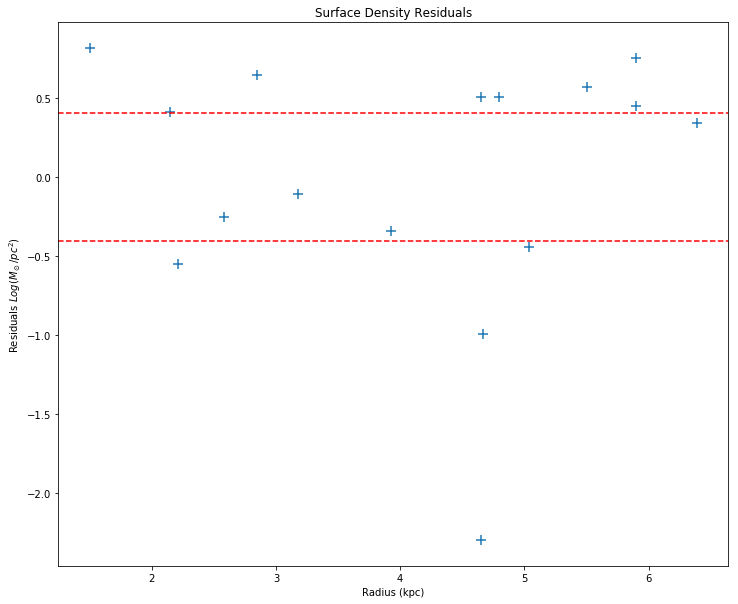

mad(Residual): 0.4036573040875175


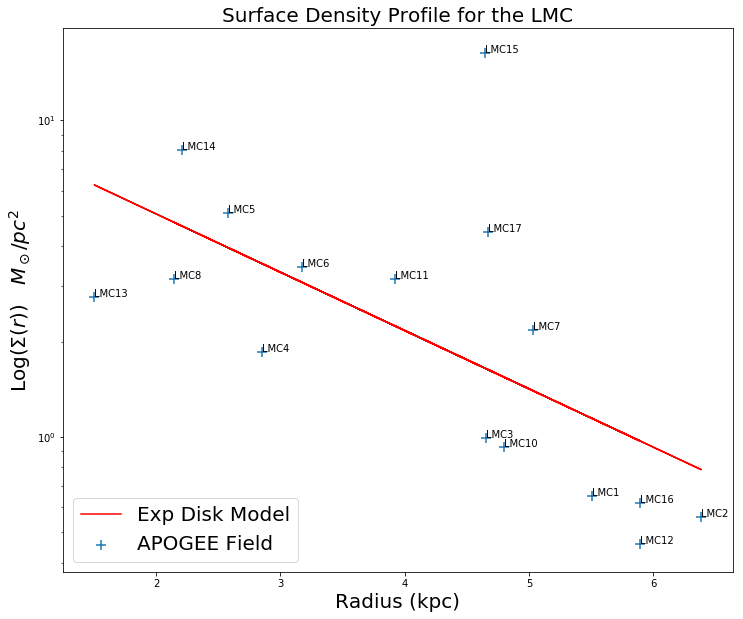

In [139]:
mp_surfden = []
for i in range(len(mp_field_masses)):
    mp_surfden.append(np.divide(mp_field_masses[i],field_areas[i]))

field_list = [np.where(mpr13['FIELD']=='30Dor'),np.where(mpr13['FIELD']=='LMC1'),
              np.where(mpr13['FIELD']=='LMC2'),np.where(mpr13['FIELD']=='LMC3'),
              np.where(mpr13['FIELD']=='LMC4'),np.where(mpr13['FIELD']=='LMC5'),
              np.where(mpr13['FIELD']=='LMC6'),np.where(mpr13['FIELD']=='LMC7'),
              np.where(mpr13['FIELD']=='LMC8'),np.where(mpr13['FIELD']=='LMC9'),
              np.where(mpr13['FIELD']=='LMC10'),np.where(mpr13['FIELD']=='LMC11'),
              np.where(mpr13['FIELD']=='LMC12'),np.where(mpr13['FIELD']=='LMC13'),
              np.where(mpr13['FIELD']=='LMC14'),np.where(mpr13['FIELD']=='LMC15'),
              np.where(mpr13['FIELD']=='LMC16'),np.where(mpr13['FIELD']=='LMC17')]

mp_radii = []

for i in range(len(field_str)):
    mp_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(mpr13['RA'][field_list[i]],
                                                         mpr13['DEC'][field_list[i]])[0])**2 + 
                            np.median(dfunc.LMCdisk_cart(mpr13['RA'][field_list[i]],
                                                         mpr13['DEC'][field_list[i]])[1])**2))
    
good = np.where(np.asarray(mp_surfden)>0.0)

mp_radii = np.asarray(mp_radii)[good]
mp_surfden = np.asarray(mp_surfden)[good]


# fit MP model
model = np.array([mp_radii]).T
model = sm.add_constant(model)
model_model = sm.OLS(np.log(mp_surfden),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(mp_surfden)
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))

plt.figure(figsize=[12,10])
plt.scatter(mp_radii,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
plt.show()
print('mad(Residual):',dfunc.mad(model_residual))

def mpprofile(r):
    p = [ 2.46941588, -0.42413729]
    return p[0]+np.multiply(p[1],r)

rad_labels = ['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
rad_labels = np.asarray(rad_labels)[good]

plt.figure(figsize=[12,10])

plt.scatter(mp_radii,mp_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
for i in range(len(mp_radii)):
    plt.text(mp_radii[i],mp_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mpprofile.pdf',bbox_inches='tight')
plt.show()

## Metal Intermediate

In [126]:
mint_iso_ages = []
mint_iso_zs = []

#fnt and brt bins
mint_fbins = dfunc.brtfntlmc_bins(mintr13)

for i in range(len(field_str)):
    fd = np.where(mintr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mintages[fd]),np.median(mintr13[fd]['FE_H']))
    mint_iso_ages.append(age)
    mint_iso_zs.append(z)

mint_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mintr13['FIELD']==field_str[i]) 
    mint_absHs.append(np.asarray(mintabsH)[field_H])

mint_sf_brites = []
mint_sf_faints = []
for i,j in enumerate(fbins):
    if i in np.arange(len(mint_fbins))[1::2]:
        mint_sf_brites.append(mintr13[mint_fbins[j]]['SELECTFUNC'])
    if i in np.arange(len(mint_fbins))[0::2]:
        mint_sf_faints.append(mintr13[mint_fbins[j]]['SELECTFUNC'])
        
mint_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mint_field_masses.append(dfunc.fieldmass(mint_iso_ages[i],mint_iso_zs[i],mint_absHs[i],mint_sf_brites[i],
                                               mint_sf_faints[i],parsec))
    except:
        mint_field_masses.append(-9999.0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     31.50
Date:                Thu, 02 Apr 2020   Prob (F-statistic):           4.95e-05
Time:                        23:04:11   Log-Likelihood:                -20.184
No. Observations:                  17   AIC:                             44.37
Df Residuals:                      15   BIC:                             46.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2553      0.523     10.046      0.0

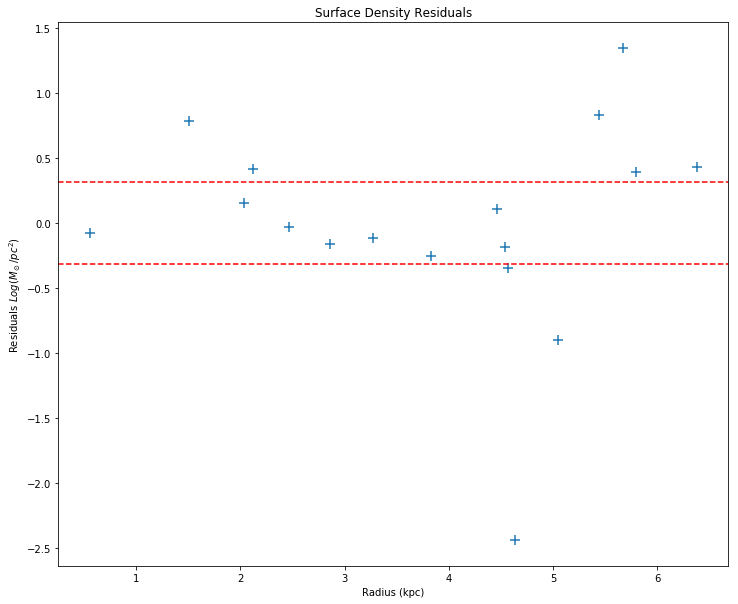

mad(Residual): 0.31429052970465765


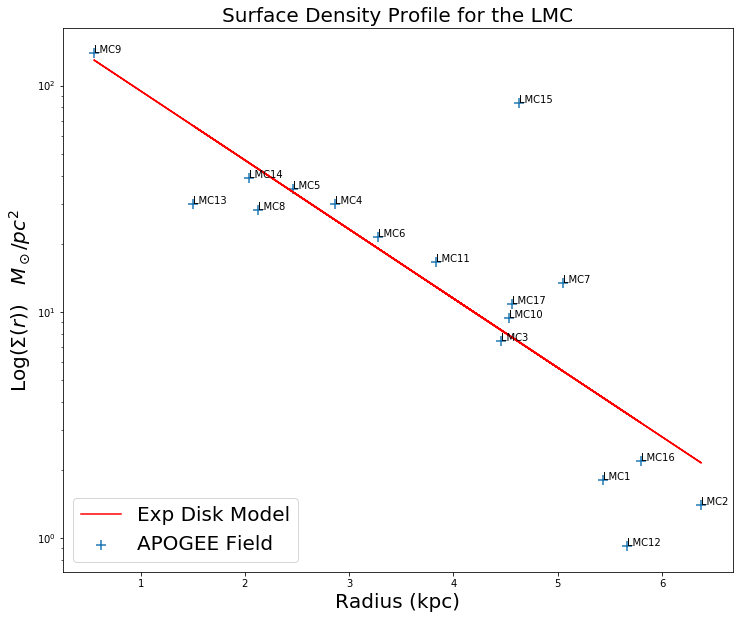

In [141]:
mint_surfden = []
for i in range(len(mint_field_masses)):
    mint_surfden.append(np.divide(mint_field_masses[i],field_areas[i]))

field_list = [np.where(mintr13['FIELD']=='30Dor'),np.where(mintr13['FIELD']=='LMC1'),
              np.where(mintr13['FIELD']=='LMC2'),np.where(mintr13['FIELD']=='LMC3'),
              np.where(mintr13['FIELD']=='LMC4'),np.where(mintr13['FIELD']=='LMC5'),
              np.where(mintr13['FIELD']=='LMC6'),np.where(mintr13['FIELD']=='LMC7'),
              np.where(mintr13['FIELD']=='LMC8'),np.where(mintr13['FIELD']=='LMC9'),
              np.where(mintr13['FIELD']=='LMC10'),np.where(mintr13['FIELD']=='LMC11'),
              np.where(mintr13['FIELD']=='LMC12'),np.where(mintr13['FIELD']=='LMC13'),
              np.where(mintr13['FIELD']=='LMC14'),np.where(mintr13['FIELD']=='LMC15'),
              np.where(mintr13['FIELD']=='LMC16'),np.where(mintr13['FIELD']=='LMC17')]

mint_radii = []

for i in range(len(field_str)):
    mint_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(mintr13['RA'][field_list[i]],
                                                         mintr13['DEC'][field_list[i]])[0])**2 + 
                            np.median(dfunc.LMCdisk_cart(mintr13['RA'][field_list[i]],
                                                         mintr13['DEC'][field_list[i]])[1])**2))
    
good = np.where(np.asarray(mint_surfden)>0.0)

mint_radii = np.delete(np.asarray(mint_radii)[good],0)
mint_surfden = np.delete(np.asarray(mint_surfden)[good],0)


# fit MInt model
model = np.array([mint_radii]).T
model = sm.add_constant(model)
model_model = sm.OLS(np.log(mint_surfden),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(mint_surfden)
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))

plt.figure(figsize=[12,10])
plt.scatter(mint_radii,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
plt.show()
print('mad(Residual):',dfunc.mad(model_residual))

def mintprofile(r):
    p = [ 5.25533047, -0.704755 ]
    return p[0]+np.multiply(p[1],r)

rad_labels = ['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
rad_labels = np.delete(np.asarray(rad_labels)[good],0)

plt.figure(figsize=[12,10])

plt.scatter(mint_radii,mint_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
for i in range(len(mint_radii)):
    plt.text(mint_radii[i],mint_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(mint_radii,np.exp(mintprofile(mint_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mintprofile.pdf',bbox_inches='tight')
plt.show()

## Metal Rich

In [136]:
mr_iso_ages = []
mr_iso_zs = []

#fnt and brt bins
mr_fbins = dfunc.brtfntlmc_bins(mrr13)

for i in range(len(field_str)):
    fd = np.where(mrr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mrages[fd]),np.median(mrr13[fd]['FE_H']))
    mr_iso_ages.append(age)
    mr_iso_zs.append(z)

mr_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mrr13['FIELD']==field_str[i]) 
    mr_absHs.append(np.asarray(mrabsH)[field_H])

mr_sf_brites = []
mr_sf_faints = []
for i,j in enumerate(fbins):
    if i in np.arange(len(mr_fbins))[1::2]:
        mr_sf_brites.append(mrr13[mr_fbins[j]]['SELECTFUNC'])
    if i in np.arange(len(mr_fbins))[0::2]:
        mr_sf_faints.append(mrr13[mr_fbins[j]]['SELECTFUNC'])
        
mr_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mr_field_masses.append(dfunc.fieldmass(mr_iso_ages[i],mr_iso_zs[i],mr_absHs[i],mr_sf_brites[i],
                                               mr_sf_faints[i],parsec))
    except:
        mr_field_masses.append(-9999.0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     8.409
Date:                Thu, 02 Apr 2020   Prob (F-statistic):             0.0199
Time:                        23:08:02   Log-Likelihood:                -12.271
No. Observations:                  10   AIC:                             28.54
Df Residuals:                       8   BIC:                             29.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8293      0.702      5.455      0.0

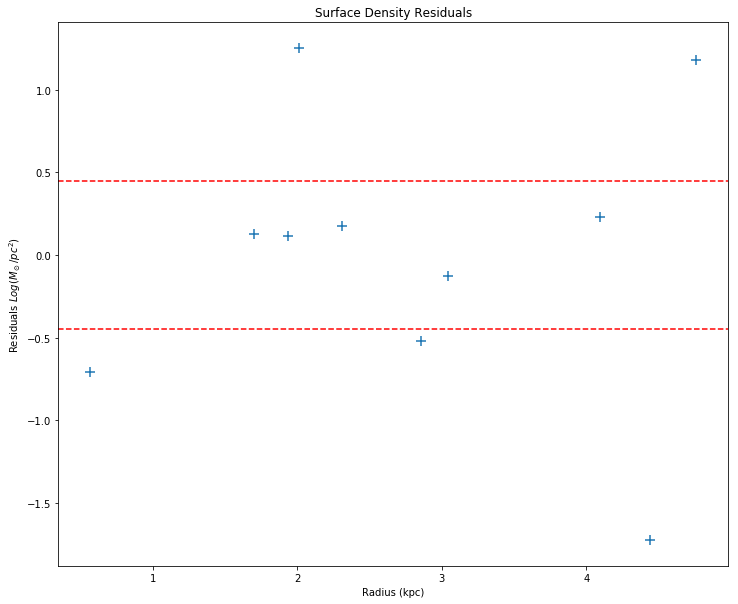

mad(Residual): 0.4450717421355066


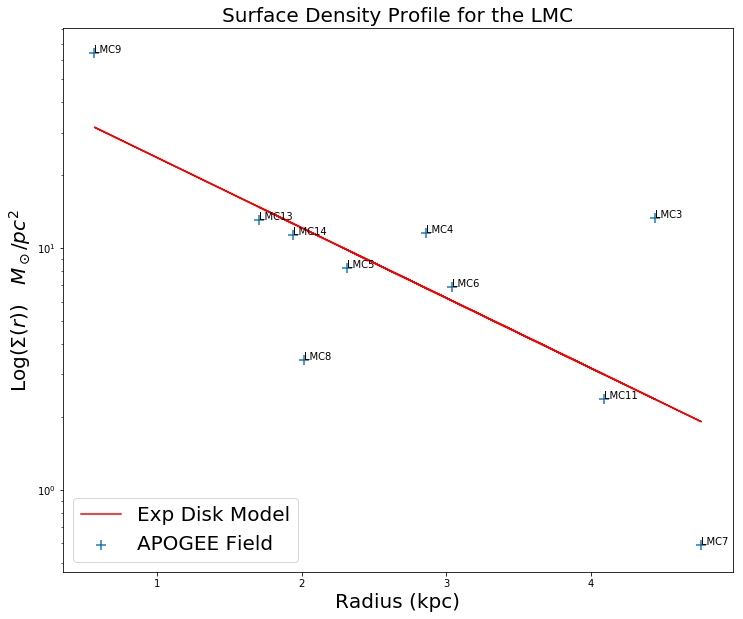

In [146]:
mr_surfden = []
for i in range(len(mr_field_masses)):
    mr_surfden.append(np.divide(mr_field_masses[i],field_areas[i]))

field_list = [np.where(mrr13['FIELD']=='30Dor'),np.where(mrr13['FIELD']=='LMC1'),
              np.where(mrr13['FIELD']=='LMC2'),np.where(mrr13['FIELD']=='LMC3'),
              np.where(mrr13['FIELD']=='LMC4'),np.where(mrr13['FIELD']=='LMC5'),
              np.where(mrr13['FIELD']=='LMC6'),np.where(mrr13['FIELD']=='LMC7'),
              np.where(mrr13['FIELD']=='LMC8'),np.where(mrr13['FIELD']=='LMC9'),
              np.where(mrr13['FIELD']=='LMC10'),np.where(mrr13['FIELD']=='LMC11'),
              np.where(mrr13['FIELD']=='LMC12'),np.where(mrr13['FIELD']=='LMC13'),
              np.where(mrr13['FIELD']=='LMC14'),np.where(mrr13['FIELD']=='LMC15'),
              np.where(mrr13['FIELD']=='LMC16'),np.where(mrr13['FIELD']=='LMC17')]

mr_radii = []

for i in range(len(field_str)):
    mr_radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(mrr13['RA'][field_list[i]],
                                                         mrr13['DEC'][field_list[i]])[0])**2 + 
                            np.median(dfunc.LMCdisk_cart(mrr13['RA'][field_list[i]],
                                                         mrr13['DEC'][field_list[i]])[1])**2))
    
good = np.where(np.asarray(mr_surfden)>0.0)

mr_radii = np.delete(np.asarray(mr_radii)[good],0)
mr_surfden = np.delete(np.asarray(mr_surfden)[good],0)


# fit mr model
model = np.array([mr_radii]).T
model = sm.add_constant(model)
model_model = sm.OLS(np.log(mr_surfden),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(mr_surfden)
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))

plt.figure(figsize=[12,10])
plt.scatter(mr_radii,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
plt.show()
print('mad(Residual):',dfunc.mad(model_residual))

def mrprofile(r):
    p = [ 3.82929628, -0.66773169]
    return p[0]+np.multiply(p[1],r)

rad_labels = ['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']
rad_labels = np.delete(np.asarray(rad_labels)[good],0)

plt.figure(figsize=[12,10])

plt.scatter(mr_radii,mr_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
for i in range(len(mr_radii)):
    plt.text(mr_radii[i],mr_surfden[i],'{}'.format(rad_labels[i]))
plt.plot(mr_radii,np.exp(mrprofile(mr_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mrprofile.pdf',bbox_inches='tight')
plt.show()

## Plot All Profiles

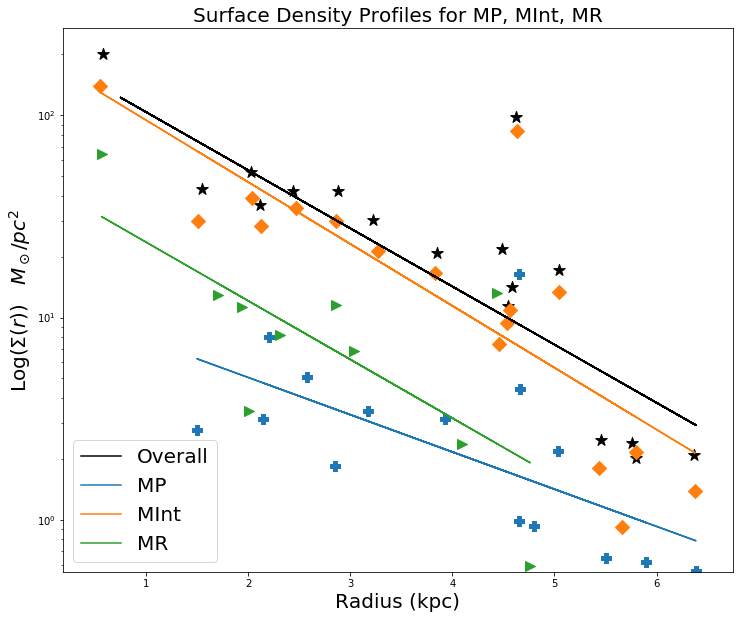

In [154]:
plt.figure(figsize=[12,10])

def lmcdensityprofile(r):
    p = [ 5.30458805, -0.66202375]
    return p[0]+np.multiply(p[1],r)

def mpprofile(r):
    p = [ 2.46941588, -0.42413729]
    return p[0]+np.multiply(p[1],r)

def mintprofile(r):
    p = [ 5.25533047, -0.704755 ]
    return p[0]+np.multiply(p[1],r)

def mrprofile(r):
    p = [ 3.82929628, -0.66773169]
    return p[0]+np.multiply(p[1],r)


plt.plot(radii,np.exp(lmcdensityprofile(radii)),c='k',label='Overall')
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='tab:blue',label='MP')
plt.plot(mint_radii,np.exp(mintprofile(mint_radii)),c='tab:orange',label='MInt')
plt.plot(mr_radii,np.exp(mrprofile(mr_radii)),c='tab:green',label='MR')

plt.legend(loc='lower left',fontsize=20)

plt.scatter(radii_rm30dor,surfden_rm30dor,marker='*',c='k',s=150)
plt.scatter(mp_radii,mp_surfden,marker='P',c='tab:blue',s=100)
plt.scatter(mint_radii,mint_surfden,marker='D',c='tab:orange',s=100)
plt.scatter(mr_radii,mr_surfden,marker='>',c='tab:green',s=100)

plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profiles for MP, MInt, MR',fontsize=20)

plt.savefig('profiles.pdf',bbox_inches='tight')
plt.show()